# Лабораторная работа №4

Липанин Михаил Дмитриевич, БИВТ-20-1

был выбран датасет "sasha/dog-food", т.к. датасет "keremberke/indoor-scene-classification" зависал на [15] шаге


# 1.Добавим необходимые зависимости и загрузим датасет



In [1]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
dataset=load_dataset('sasha/dog-food')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sasha___parquet/sasha--dog-food-ec42a61d5519cc88/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# 2. Описываем датасет

In [3]:
labels=dataset["test"].features["label"].names
labelMapToid,idMapTolabel=dict(),dict()
for i, label in enumerate(labels):
    print(i,label)
    labelMapToid[label]=i
    idMapTolabel[i]=label

0 dog
1 food


In [4]:
example=dataset['train'][3]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 900
    })
})

In [6]:
example['label']

0

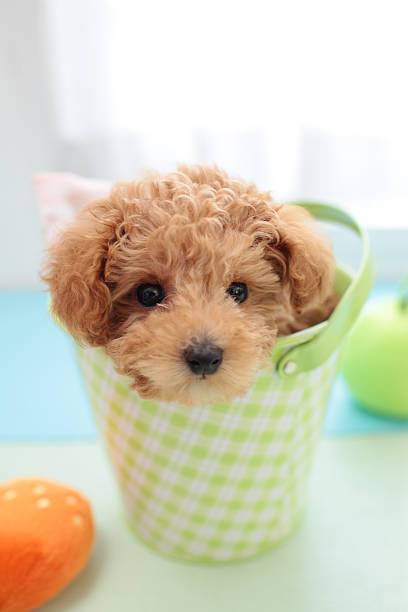

In [7]:
example['image']

### В датасете содержится 2100 тренировочных и 900 тестовых данных. В них находятся изображения собак и еды и подписи. После обучения нейросеть должна уметь отличать собак от еды.




# 3. Оформим датасет в виде объекта класса Dataset из PyTorch

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

In [9]:
class IsItFoodOrDog(torch.utils.data.Dataset):
  def __init__(self, dataset):
      self.dataset=dataset
      self.transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224),antialias=True),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

  def get_labels(self, index):
      return self.dataset[index]['label']

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self, index):
      train_images=self.get_images(index)
      train_labels=self.get_labels(index)
      return train_images,train_labels
    
  def get_images(self, index):
      return self.transform(self.dataset[index]['image'])

In [10]:
train_dataset=IsItFoodOrDog(dataset["train"])
test_dataset=IsItFoodOrDog(dataset["test"])

# 4. Оформим датасет в Dataloader

In [11]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [12]:
class_names=dataset["test"].features["label"].names
dataset_sizes = {
    'train':len(dataset['train']),
    'test':len(dataset['test']),
}

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 5. Выведем наш датасет




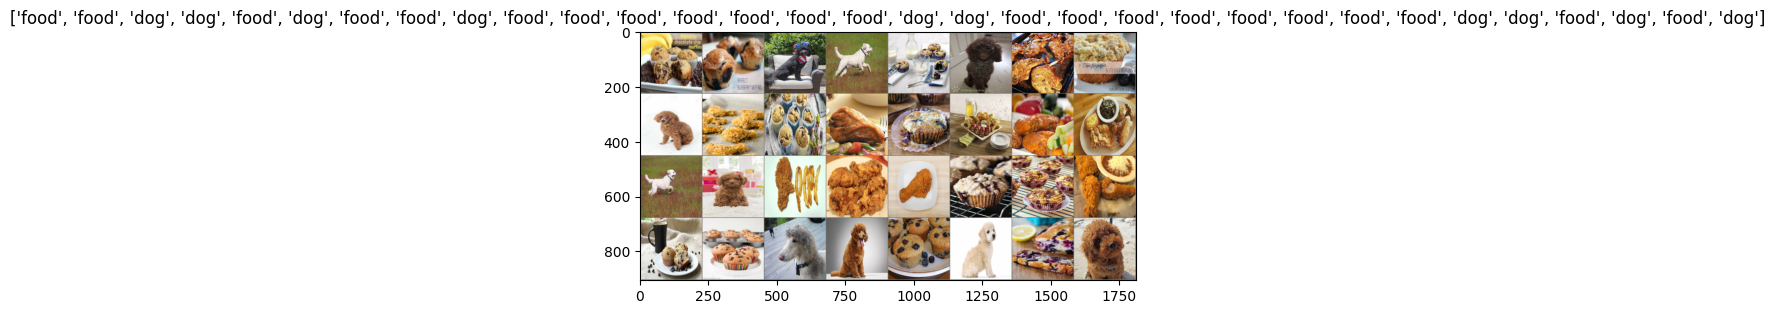

In [13]:
def imshow(inp, title=None):
    inp=inp.numpy().transpose((1,2,0)) 
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs,classes=next(iter(train_dataloader))
out=torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

# 6. Реализуем собственную нейросеть

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since=time.time()
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0

    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss=0.0
            running_corrects=0

            current_dataloader=train_dataloader
            if phase=='test':
                current_dataloader=test_dataloader
            for inputs, labels in current_dataloader:
                inputs=inputs.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs=model(inputs)
                    _, preds=torch.max(outputs, 1)
                    loss=criterion(outputs, labels)


                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase=='train':
                scheduler.step()

            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            if (epoch_acc>best_acc):
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} | Accurancy: {:.4f}'.format(
                phase,epoch_loss,epoch_acc))
        print()

    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model
  

In [15]:
model=nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(64),

    nn.Flatten(),

    nn.Linear(576, 32),
    nn.Linear(32, 2),
)

model=model.to(device)
criterion=nn.CrossEntropyLoss().to(device)
optimizer_ft=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=3,gamma=0.1)
model_fitted=train_model(model,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=10)

Epoch [1/10]
----------
train Loss: 0.5996 | Accurancy: 0.7362
test Loss: 0.6990 | Accurancy: 0.8389

Epoch [2/10]
----------
train Loss: 0.5262 | Accurancy: 0.7881
test Loss: 0.3134 | Accurancy: 0.8722

Epoch [3/10]
----------
train Loss: 0.4031 | Accurancy: 0.8290
test Loss: 0.3874 | Accurancy: 0.8544

Epoch [4/10]
----------
train Loss: 0.3439 | Accurancy: 0.8495
test Loss: 0.3141 | Accurancy: 0.8789

Epoch [5/10]
----------
train Loss: 0.3178 | Accurancy: 0.8595
test Loss: 0.2722 | Accurancy: 0.8956

Epoch [6/10]
----------
train Loss: 0.3191 | Accurancy: 0.8633
test Loss: 0.2780 | Accurancy: 0.8967

Epoch [7/10]
----------
train Loss: 0.2997 | Accurancy: 0.8657
test Loss: 0.2686 | Accurancy: 0.9033

Epoch [8/10]
----------
train Loss: 0.2978 | Accurancy: 0.8710
test Loss: 0.2665 | Accurancy: 0.9033

Epoch [9/10]
----------
train Loss: 0.2970 | Accurancy: 0.8786
test Loss: 0.2648 | Accurancy: 0.9033

Epoch [10/10]
----------
train Loss: 0.2991 | Accurancy: 0.8724
test Loss: 0.2650 

# Выведем результаты обучения для наглядности

In [16]:
def predict(img):
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224,224),antialias=True),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
    img=transform(img)
    output=model_fitted(img.unsqueeze(0).to(device))
    prediction=output.argmax(dim=1).item()

    return idMapTolabel[prediction]

In [17]:
def visualize_model(model, num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            outputs=model(inputs)
            _, preds=torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax=plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

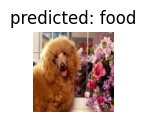

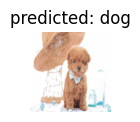

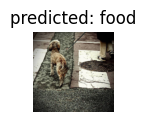

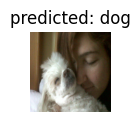

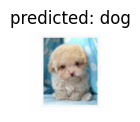

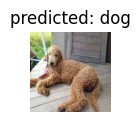

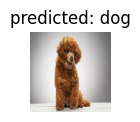

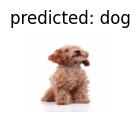

In [19]:
visualize_model(model_fitted,8)

# Обучение с Transfer Learning -- ResNet152

In [20]:
model_ft=models.resnet152(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs, 2)
model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss().to(device)
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.01,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=1,gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 123MB/s]


In [21]:
model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=10)

Epoch [1/10]
----------
train Loss: 0.0414 | Accurancy: 0.9819
test Loss: 0.0208 | Accurancy: 0.9967

Epoch [2/10]
----------
train Loss: 0.0076 | Accurancy: 0.9981
test Loss: 0.0022 | Accurancy: 0.9989

Epoch [3/10]
----------
train Loss: 0.0002 | Accurancy: 1.0000
test Loss: 0.0048 | Accurancy: 0.9989

Epoch [4/10]
----------
train Loss: 0.0003 | Accurancy: 1.0000
test Loss: 0.0025 | Accurancy: 0.9989

Epoch [5/10]
----------
train Loss: 0.0015 | Accurancy: 0.9995
test Loss: 0.0046 | Accurancy: 0.9989

Epoch [6/10]
----------
train Loss: 0.0034 | Accurancy: 0.9990
test Loss: 0.0047 | Accurancy: 0.9989

Epoch [7/10]
----------
train Loss: 0.0010 | Accurancy: 0.9995
test Loss: 0.0041 | Accurancy: 0.9989

Epoch [8/10]
----------
train Loss: 0.0021 | Accurancy: 0.9986
test Loss: 0.0056 | Accurancy: 0.9989

Epoch [9/10]
----------
train Loss: 0.0019 | Accurancy: 0.9995
test Loss: 0.0033 | Accurancy: 0.9989

Epoch [10/10]
----------
train Loss: 0.0025 | Accurancy: 0.9995
test Loss: 0.0050 

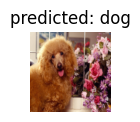

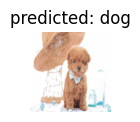

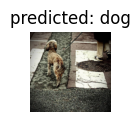

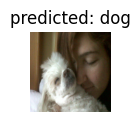

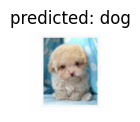

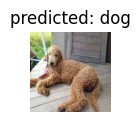

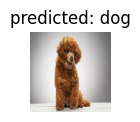

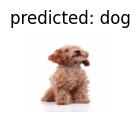

In [22]:
visualize_model(model_ft,8)

# Результаты 

После обучения собственная модель имела:
- train Loss: 0.2970 | Accurancy: 0.8786
- test Loss: 0.2648 | Accurancy: 0.9033
- Best val Acc: 0.903333

После Transfer Learning на ResNet152 получили:
- train Loss: 0.0003 | Accurancy: 1.0000
- test Loss: 0.0025 | Accurancy: 0.9989
- Best val Acc: 1.000000

После обучения, можно увидеть внушительно-большое значение val Acc, что позволяет практически безошибочно отличать собак от еды.